# Kuramoto Model 
This notebook simulates kuramoto models, both with and without noise.
Mia Morrell

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sdeint import itoint
import matplotlib
import matplotlib.patches as mpatches

In [2]:
def r(thetas):
    """
    compute the order parameter r(t). For a given time t_0, the order parameter is 
    r(t_0) = (1/N)sum_{j=0}^{N} e^{i\theta_j(t_0)}
    """
    summed = sum([(np.exp(1j * theta)) for theta in thetas])
    return abs(summed / len(thetas))
    
class Kuramoto:

    def __init__(self, nat_freqs, init_thetas, coupling, coup_mat, dt=0.01, T=10):
        """
        run kuramoto model, no noise added
        -----------------------------------------------------------------------
        nat_freqs: array, natural oscillation frequency for each oscillator
        init_thetas: initial condition of theta for each oscillator
        coupling: float, coupling strength. uniform for all oscillators
        coup_mat: the coupling matrix that defines interactions between oscillators
        dt: float, time step for integration
        T: float, total simulation time
        """
        self.dt = dt
        self.T = T
        self.coupling = coupling
        self.coup_mat = coup_mat
        self.nat_freqs = nat_freqs
        self.num_osc = len(nat_freqs)
        self.init_thetas = init_thetas


    def dtheta_dt(self, init_thetas, t):
        """
        compute derivative of all thetas
        
        the strategy here is to define a matrix that holds sin(theta_j-theta_i) for each
        oscillator i and then multiply the diagonal of this matrix by 0 to get rid of 
        each oscillator's interaction with itself.
        ----------------------------------------------------------------------
        t: for compatibility with scipy.odeint
        """
        theta_is, theta_js = np.meshgrid(init_thetas, init_thetas)  #make theta_is and theta_js matrix.
                                                                   #subtracting these matrices will yield
                                                                   #a matrix that holds (theta_j-theta_i) for
                                                                   #each oscillator theta_i
                    
        # calculate change in theta
        dthetadt=self.nat_freqs+self.coupling/self.coup_mat.sum(axis=0)*\
            (self.coup_mat * np.sin(theta_js - theta_is)).sum(axis=0) 
        return dthetadt

    def thetas_t(self, init_thetas):
        """
        integrates dtheta_dt to get phase angle for each oscillator as a function of time
        ------------------------------------------------------------------------
        init_thetas: initial condition of theta for each oscillator
        """
        t = np.linspace(0, self.T, int(self.T/self.dt))
        thetast = odeint(self.dtheta_dt, self.init_thetas, t)
        return thetast.T  

    def run(self, init_thetas):
        """
        run the kuramoto model with the specified parameters
        """
        return self.thetas_t(init_thetas)

In [3]:

class Noisy_Kuramoto:
    def __init__(self, nat_freqs, init_thetas, coupling, coup_mat, dt=0.01, T=10, noise_std = 0.01):
        """
        run kuramoto model, noise added
        -----------------------------------------------------------------------
        nat_freqs: array, natural oscillation frequency for each oscillator
        init_thetas: initial condition of theta for each oscillator
        coupling: float, coupling strength. uniform for all oscillators
        coup_mat: the coupling matrix that defines interactions between oscillators
        dt: float, time step for integration
        T: float, total simulation time
        noise_std: standard deviation of white noise added to the differential equation for the change in theta
        """
        self.dt = dt
        self.T = T
        self.coupling = coupling
        self.coup_mat = coup_mat
        self.nat_freqs = nat_freqs
        self.num_osc = len(nat_freqs)
        self.init_thetas = init_thetas
        self.noise_std = noise_std


    def dtheta_dt(self, init_thetas, t):
        """
        compute derivative of all thetas
        
        the strategy here is to define a matrix that holds sin(theta_j-theta_i) for each
        oscillator i and then multiply the diagonal of this matrix by 0 to get rid of 
        each oscillator's interaction with itself.
        ----------------------------------------------------------------------
        t: for compatibility with scipy.odeint
        """
        theta_is, theta_js = np.meshgrid(init_thetas, init_thetas) #make theta_is and theta_js matrix.
                                                                   #subtracting these matrices will yield
                                                                   #a matrix that holds (theta_j-theta_i) for
                                                                   #each oscillator theta_i
                    
        # calculate change in theta
        dthetadt=self.nat_freqs+self.coupling/self.coup_mat.sum(axis=0)*\
            (self.coup_mat * np.sin(theta_js - theta_is)).sum(axis=0) 
        return dthetadt

    def g(self, init_thetas, t):
        """
        add noise to dtheta_dt
        
        this is formatted to work with the stochastic integration function itoint
        
        note that white noise is the derivative of a Weiner process
        -------------------------------------------------------------
        init_thetas: initial condition of theta for each oscillator
        """
        B = np.zeros((len(init_thetas),len(init_thetas)))
        np.fill_diagonal(B, 0.5)
        return self.noise_std*B
    
    def thetas_t(self, init_thetas):
        """
        integrates dtheta_dt to get phase angle for each oscillator as a function of time
        ------------------------------------------------------------------------
        init_thetas: initial condition of theta for each oscillator
        """
        t = np.linspace(0, self.T, int(self.T/self.dt))
        thetast = itoint(self.dtheta_dt, self.g, self.init_thetas, t)
        return thetast.T  

    def run(self, init_thetas):
        """
        run the noisy kuramoto model with the specified parameters
        """
        return self.thetas_t(init_thetas)


### Fig. 1
Results for 100 oscillators with initial phase angles drawn from $\mathcal{U}[-2\pi, 2\pi]$, natural frequencies drawn from $\mathcal{N}[0,1]$, and strong coupling strength ($K=3.0$), and phase angle evolution according to the Kuramoto model. A: Variance of phase angle $\theta_i$ over oscillators as a function of time step. B: Phase angle $\theta_i$ for each oscillator $i$ as a function of time step. Different oscillators are represented as different colors. C: Order parameter $r$ as a function of time step. D-F: Position of each oscillator on the unit circle at the following time steps: 0, 200, 1000, and 4999.

In [4]:
# set up couplings matrix
num_osc = 100
np.random.seed(10)
nat_freqs = np.random.normal(size=num_osc)  # reset natural frequencies
np.random.seed(20)
init_thetas = 2 * np.pi * np.random.random(size=num_osc)
np.random.seed()
coup_mat = np.ones((num_osc, num_osc))
np.fill_diagonal(coup_mat, 0.0)
coupling = 3.0


model = Kuramoto(nat_freqs, init_thetas, coupling, coup_mat, dt=0.01, T=50)
theta_mat = model.run(init_thetas)

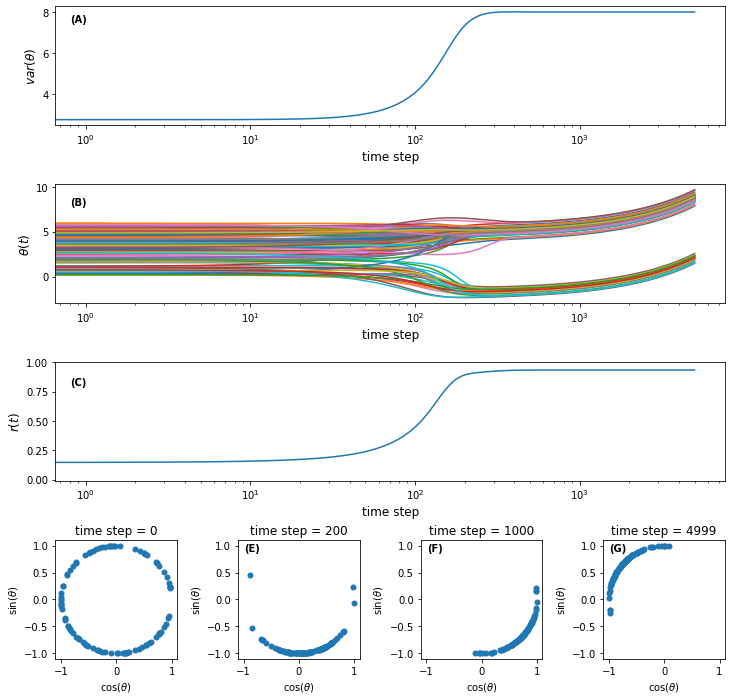

In [5]:
fig = plt.figure(figsize=(12, 12))

rows = 4
columns = 4

grid = plt.GridSpec(rows, columns, wspace = .5, hspace = .5)

plt.subplot(grid[0, :])
plt.semilogx(np.var(theta_mat, axis=0))
plt.xlabel('time step', fontsize=12)
plt.ylabel(r'$var(\theta)$', fontsize=12)
plt.text(0.8, 7.5, '(A)', weight = 'bold')

plt.subplot(grid[1, :])
for i in range(theta_mat.shape[0]):
    plt.semilogx((np.arange(0, theta_mat.shape[1])), ((theta_mat)[i]))
plt.xlabel('time step', fontsize=12)
plt.ylabel(r'$\theta(t)$', fontsize=12)
plt.text(0.8, 8, '(B)', weight = 'bold')

plt.subplot(grid[2, :])
plt.semilogx([r(thetat) for thetat in theta_mat.T])
plt.ylabel('$r(t)$', fontsize=12)
plt.xlabel('time step', fontsize=12)
plt.ylim((-0.01, 1))
plt.text(0.8, 0.8, '(C)', weight = 'bold')


plt.subplot(grid[3, 0])
t=0
plt.plot(np.cos(theta_mat[:, t]),np.sin(theta_mat[:, t]),'.',markersize=10)
plt.title(f'time step = {t}')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel(r'$\sin(\theta)$')
plt.xlabel(r'$\cos(\theta)$')
#plt.text(-0.99, 0.9, '(D)', weight = 'bold')

plt.subplot(grid[3, 1])
t=200
plt.plot(np.cos(theta_mat[:, t]),np.sin(theta_mat[:, t]),'.',markersize=10)
plt.title(f'time step = {t}')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel(r'$\sin(\theta)$')
plt.xlabel(r'$\cos(\theta)$')
plt.text(-0.99, 0.9, '(E)', weight = 'bold')

plt.subplot(grid[3, 2])
t=1000
plt.plot(np.cos(theta_mat[:, t]),np.sin(theta_mat[:, t]),'.',markersize=10)
plt.title(f'time step = {t}')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel(r'$\sin(\theta)$')
plt.xlabel(r'$\cos(\theta)$')
plt.text(-0.99, 0.9, '(F)', weight = 'bold')

plt.subplot(grid[3, 3])
t=4999
plt.plot(np.cos(theta_mat[:, t]),np.sin(theta_mat[:, t]),'.',markersize=10)
plt.title(f'time step = {t}')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.ylabel(r'$\sin(\theta)$')
plt.xlabel(r'$\cos(\theta)$')
plt.text(-0.99, 0.9, '(G)', weight = 'bold')


plt.savefig('kuramoto_fig1.png')

### Fig. 2
Order parameter results for 100 oscillators with natural frequencies drawn from $\mathcal{N}(1.0, 0.1)$, initial phase angles drawn from $\mathcal{U}[-2\pi, 2\pi]$, varying coupling strength. A: Order parameter $r$ as a function of time step for coupling constants ranging between 0.0 and 0.6, holding all other parameters constant. B: Time average of order parameter $r$ as a function of coupling constant $K$, holding all other parameters constant.

In [6]:
# set up couplings matrix
num_osc = 100
np.random.seed(1)
nat_freqs = np.random.normal(1, 0.1, size=num_osc)  # reset natural frequencies
np.random.seed(2)
init_thetas = 2 * np.pi * np.random.random(size=num_osc)
np.random.seed()
coup_mat = np.ones((num_osc, num_osc))
np.fill_diagonal(coup_mat, 0.0)

Kc = np.sqrt(8/np.pi)*0.1
# Run model with different coupling (K) parameters
couplings = np.linspace(0, 0.6, 50)


iters = []
for coupling in couplings:
    model = Kuramoto(nat_freqs, init_thetas, coupling, coup_mat, dt=0.1, T=300)
    theta_mat = model.run(init_thetas)
    iters.append(theta_mat)

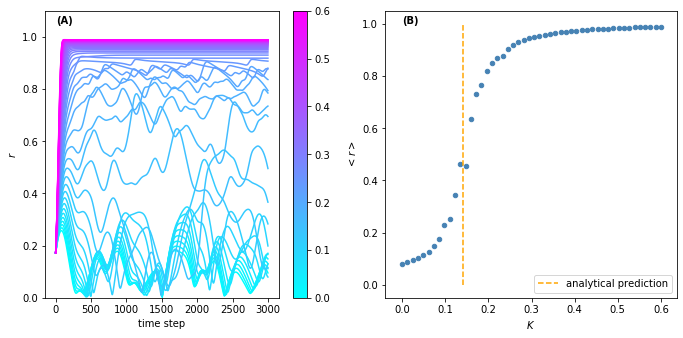

In [7]:

# Plot all time series for all coupling values (color coded)
iters = np.array(iters)
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (8*1.2,4*1.2))
norm = matplotlib.colors.Normalize(
    vmin=np.min(couplings),
    vmax=np.max(couplings))

# choose a colormap
c_m = matplotlib.cm.cool

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])
for i, coupling in enumerate(couplings):
    ax[0].plot([r(thetat) for thetat in iters[i, :, :].T],color=s_m.to_rgba(coupling))
ax[0].set_ylabel(r'$r$')
ax[0].set_xlabel('time step')
ax[0].set_ylim(0, 1.1)
ax[0].text(0, 1.05, '(A)', weight = 'bold')
plt.colorbar(s_m, ax = ax[0])


for i, coupling in enumerate(couplings):
    r_mean = np.mean([r(thetat)
                      for thetat in iters[i, :, -1000:].T]) # mean over last 1000 steps
    plt.scatter(coupling, r_mean, c='steelblue', s=20)

# Predicted Kc – analytical result (from paper)
Kc = np.sqrt(8 / np.pi) * np.std(model.nat_freqs) # analytical result (from paper)
ax[1].vlines(Kc, 0, 1, linestyles='--', color='orange', label='analytical prediction')

plt.legend(loc = 'lower right')
ax[1].set_ylabel('$<r>$')
ax[1].set_xlabel('$K$')
ax[1].text(0, 1.0, '(B)', weight = 'bold')

plt.tight_layout()

plt.savefig('kuramoto_fig2.png')

### Fig. 3
Result of adding noise to the Kuramoto model. A: Order parameter $r$ as a function of time step for clean Kuramoto model (red), noisy Kuramoto model with white noise standard deviation of 2.0 (green), and noisy Kuramoto model with white noise standard deviation of 10.0 (blue). B-D:} Phase angle $\theta_i$ as a function of time step for the clean Kuramoto model (B), noisy Kuramoto model with white noise standard deviation of 2.0 (C), and noisy Kuramoto model with white noise standard deviation of 10.0 (D). For all results in this figure, 100 oscillators are simulated with natural frequencies drawn from $\mathcal{N}(0, 1)$, initial phase angles drawn from $\mathcal{U}[-2\pi, 2\pi]$, and coupling $K=3.0$.

In [8]:
# set up couplings matrix
num_osc = 100
np.random.seed(1)
nat_freqs = np.random.normal(size=num_osc)
np.random.seed(2)
init_thetas = 2 * np.pi * np.random.random(size=num_osc)
np.random.seed()
coup_mat = np.ones((num_osc, num_osc))
np.fill_diagonal(coup_mat, 0.0)
coupling = 3.0


model = Kuramoto(nat_freqs, init_thetas, coupling, coup_mat, dt=0.01, T=50)
theta_mat_0 = model.run(init_thetas)

model = Noisy_Kuramoto(nat_freqs, init_thetas, coupling, coup_mat, dt=0.01, T=50, noise_std = 2.0)
theta_mat_1 = model.run(init_thetas)

model = Noisy_Kuramoto(nat_freqs, init_thetas, coupling, coup_mat, dt=0.01, T=50, noise_std = 10.0)
theta_mat_10 = model.run(init_thetas)


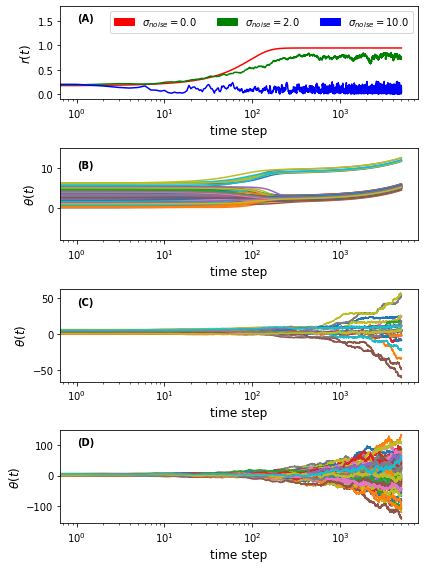

In [9]:
# Plot evolution of global order parameter R_t
fig, ax = plt.subplots(ncols = 1, nrows = 4, figsize=(6, 8))
ax[0].semilogx([r(thetat) for thetat in theta_mat_0.T], color = 'red')
ax[0].semilogx([r(thetat) for thetat in theta_mat_1.T], color = 'green')
ax[0].semilogx([r(thetat) for thetat in theta_mat_10.T], color = 'blue')
ax[0].set_ylabel('$r(t)$', fontsize=12)
ax[0].set_xlabel('time step', fontsize=12)
ax[0].set_ylim((-0.1, 1.8))
ax[0].text(1, 1.5, '(A)', weight = 'bold')

red_patch = mpatches.Patch(color='red', label = r'$\sigma_{noise} = 0.0$')
green_patch = mpatches.Patch(color='green', label = r'$\sigma_{noise} = 2.0$')
blue_patch = mpatches.Patch(color='blue', label = r'$\sigma_{noise} = 10.0$')

ax[0].legend(handles=[red_patch, green_patch, blue_patch], loc='upper right',ncol=3)

ax[1].semilogx((theta_mat_0.T))
ax[1].set_xlabel('time step', fontsize=12)
ax[1].set_ylabel(r'$\theta(t)$', fontsize=12)
ax[1].set_ylim(-8,15)
ax[1].text(1, 10.0, '(B)', weight = 'bold')

ax[2].semilogx((theta_mat_1.T))
ax[2].set_xlabel('time step', fontsize=12)
ax[2].set_ylabel(r'$\theta(t)$', fontsize=12)
ax[2].text(1, 40.0, '(C)', weight = 'bold')

ax[3].semilogx((theta_mat_10.T))
ax[3].set_xlabel('time step', fontsize=12)
ax[3].set_ylabel(r'$\theta(t)$', fontsize=12)
ax[3].text(1, 100.0, '(D)', weight = 'bold')

plt.tight_layout()

plt.savefig('kuramoto_fig3.png')

### Fig. 4
Position of each oscillator on the unit circle at the following time steps: 0, 200, 1000, and 4999 for clean Kuramoto model (A-D), noisy Kuramoto model with white noise standard deviation of 2.0 (E-H), and noisy Kuramoto model with white noise standard deviation of 10.0 (I-L). For all results in this figure, 100 oscillators are simulated with natural frequencies drawn from $\mathcal{N}(0, 1)$, initial phase angles drawn from $\mathcal{U}[-2\pi, 2\pi]$, and coupling $K=3.0$.

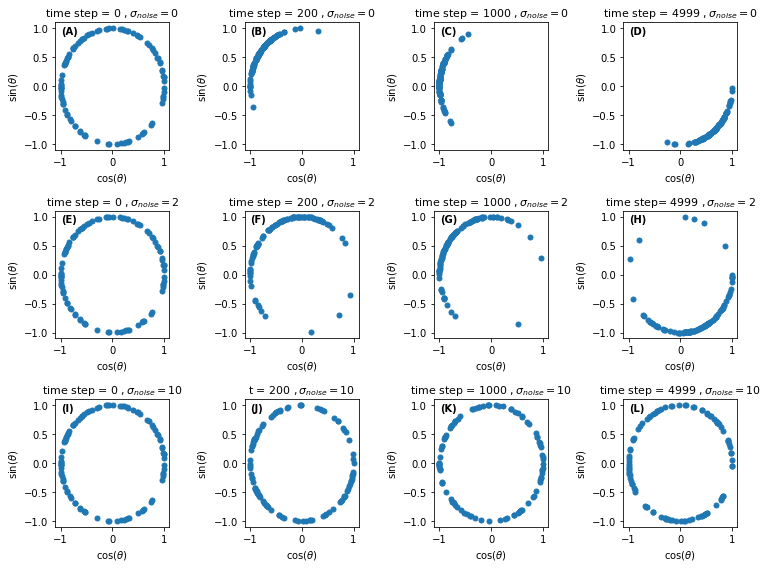

In [10]:
fig, ax= plt.subplots(ncols=4, nrows=3, figsize=(16/1.5, 12/1.5))

t=0
ax[0,0].plot(np.cos(theta_mat_0[:, t]),np.sin(theta_mat_0[:, t]),'.',markersize=10)
ax[0,0].set_title(f'time step = {t}' + ' $, \sigma_{noise} = 0$', fontsize=11)
ax[0,0].set_ylim(-1.1, 1.1)
ax[0,0].set_xlim(-1.1, 1.1)
ax[0,0].set_ylabel(r'$\sin(\theta)$')
ax[0,0].set_xlabel(r'$\cos(\theta)$')
ax[0,0].text(-0.99, 0.9, '(A)', weight = 'bold')

ax[1,0].plot(np.cos(theta_mat_1[:, t]),np.sin(theta_mat_1[:, t]),'.',markersize=10)
ax[1,0].set_title(f'time step = {t}' + ' $, \sigma_{noise} = 2$', fontsize=11)
ax[1,0].set_ylim(-1.1, 1.1)
ax[1,0].set_xlim(-1.1, 1.1)
ax[1,0].set_ylabel(r'$\sin(\theta)$')
ax[1,0].set_xlabel(r'$\cos(\theta)$')
ax[1,0].text(-0.99, 0.9, '(E)', weight = 'bold')

ax[2,0].plot(np.cos(theta_mat_10[:, t]),np.sin(theta_mat_10[:, t]),'.',markersize=10)
ax[2,0].set_title(f'time step = {t}' + ' $, \sigma_{noise} = 10$', fontsize=11)
ax[2,0].set_ylim(-1.1, 1.1)
ax[2,0].set_xlim(-1.1, 1.1)
ax[2,0].set_ylabel(r'$\sin(\theta)$')
ax[2,0].set_xlabel(r'$\cos(\theta)$')
ax[2,0].text(-0.99, 0.9, '(I)', weight = 'bold')

t=200
ax[0,1].plot(np.cos(theta_mat_0[:, t]),np.sin(theta_mat_0[:, t]),'.',markersize=10)
ax[0,1].set_title(f'time step = {t}' + ' $, \sigma_{noise} = 0$', fontsize=11)
ax[0,1].set_ylim(-1.1, 1.1)
ax[0,1].set_xlim(-1.1, 1.1)
ax[0,1].set_ylabel(r'$\sin(\theta)$')
ax[0,1].set_xlabel(r'$\cos(\theta)$')
ax[0,1].text(-0.99, 0.9, '(B)', weight = 'bold')

ax[1,1].plot(np.cos(theta_mat_1[:, t]),np.sin(theta_mat_1[:, t]),'.',markersize=10)
ax[1,1].set_title(f'time step = {t}' + ' $, \sigma_{noise} = 2$', fontsize=11)
ax[1,1].set_ylim(-1.1, 1.1)
ax[1,1].set_xlim(-1.1, 1.1)
ax[1,1].set_ylabel(r'$\sin(\theta)$')
ax[1,1].set_xlabel(r'$\cos(\theta)$')
ax[1,1].text(-0.99, 0.9, '(F)', weight = 'bold')

ax[2,1].plot(np.cos(theta_mat_10[:, t]),np.sin(theta_mat_10[:, t]),'.',markersize=10)
ax[2,1].set_title(f't = {t}' + ' $, \sigma_{noise} = 10$', fontsize=11)
ax[2,1].set_ylim(-1.1, 1.1)
ax[2,1].set_xlim(-1.1, 1.1)
ax[2,1].set_ylabel(r'$\sin(\theta)$')
ax[2,1].set_xlabel(r'$\cos(\theta)$')
ax[2,1].text(-0.99, 0.9, '(J)', weight = 'bold')

t=1000
ax[0,2].plot(np.cos(theta_mat_0[:, t]),np.sin(theta_mat_0[:, t]),'.',markersize=10)
ax[0,2].set_title(f'time step = {t}' + ' $, \sigma_{noise} = 0$', fontsize=11)
ax[0,2].set_ylim(-1.1, 1.1)
ax[0,2].set_xlim(-1.1, 1.1)
ax[0,2].set_ylabel(r'$\sin(\theta)$')
ax[0,2].set_xlabel(r'$\cos(\theta)$')
ax[0,2].text(-0.99, 0.9, '(C)', weight = 'bold')

ax[1,2].plot(np.cos(theta_mat_1[:, t]),np.sin(theta_mat_1[:, t]),'.',markersize=10)
ax[1,2].set_title(f'time step = {t}' + ' $, \sigma_{noise} = 2$', fontsize=11)
ax[1,2].set_ylim(-1.1, 1.1)
ax[1,2].set_xlim(-1.1, 1.1)
ax[1,2].set_ylabel(r'$\sin(\theta)$')
ax[1,2].set_xlabel(r'$\cos(\theta)$')
ax[1,2].text(-0.99, 0.9, '(G)', weight = 'bold')

ax[2,2].plot(np.cos(theta_mat_10[:, t]),np.sin(theta_mat_10[:, t]),'.',markersize=10)
ax[2,2].set_title(f'time step = {t}' + ' $, \sigma_{noise} = 10$', fontsize=11)
ax[2,2].set_ylim(-1.1, 1.1)
ax[2,2].set_xlim(-1.1, 1.1)
ax[2,2].set_ylabel(r'$\sin(\theta)$')
ax[2,2].set_xlabel(r'$\cos(\theta)$')
ax[2,2].text(-0.99, 0.9, '(K)', weight = 'bold')

t=4999
ax[0,3].plot(np.cos(theta_mat_0[:, t]),np.sin(theta_mat_0[:, t]),'.',markersize=10)
ax[0,3].set_title(f'time step = {t}' + ' $, \sigma_{noise} = 0$', fontsize=11)
ax[0,3].set_ylim(-1.1, 1.1)
ax[0,3].set_xlim(-1.1, 1.1)
ax[0,3].set_ylabel(r'$\sin(\theta)$')
ax[0,3].set_xlabel(r'$\cos(\theta)$')
ax[0,3].text(-0.99, 0.9, '(D)', weight = 'bold')

ax[1,3].plot(np.cos(theta_mat_1[:, t]),np.sin(theta_mat_1[:, t]),'.',markersize=10)
ax[1,3].set_title(f'time step= {t}' + ' $, \sigma_{noise} = 2$', fontsize=11)
ax[1,3].set_ylim(-1.1, 1.1)
ax[1,3].set_xlim(-1.1, 1.1)
ax[1,3].set_ylabel(r'$\sin(\theta)$')
ax[1,3].set_xlabel(r'$\cos(\theta)$')
ax[1,3].text(-0.99, 0.9, '(H)', weight = 'bold')

ax[2,3].plot(np.cos(theta_mat_10[:, t]),np.sin(theta_mat_10[:, t]),'.',markersize=10)
ax[2,3].set_title(f'time step = {t}' + ' $, \sigma_{noise} = 10$', fontsize=11)
ax[2,3].set_ylim(-1.1, 1.1)
ax[2,3].set_xlim(-1.1, 1.1)
ax[2,3].set_ylabel(r'$\sin(\theta)$')
ax[2,3].set_xlabel(r'$\cos(\theta)$')
ax[2,3].text(-0.99, 0.9, '(L)', weight = 'bold')
plt.tight_layout()

plt.savefig('kuramoto_fig4.png')

### Fig. 5:
Time average of order parameter $r$ as a function of coupling constant $K$, holding all other parameters constant, for clean Kuramoto model (red), and Kuramoto models with added noise (green, blue). The theoretical value of the critical coupling separating sychronous and asynchronous states, $K_{crit}^{(theory)} = \frac{8\sigma}{\pi}$, is marked in orange. For all results on this figure, 50 oscillators are simulated with natural frequencies drawn from $\mathcal{N}(1.0, 0.1)$, initial phase angles drawn from $\mathcal{U}[-2\pi, 2\pi]$, varying coupling strength from 0.0 to 0.6. 

In [11]:
# set up couplings matrix
num_osc = 50
np.random.seed(500)
nat_freqs = np.random.normal(1, 0.1, size=num_osc)  # reset natural frequencies
np.random.seed(600)
init_thetas = 2 * np.pi * np.random.random(size=num_osc)
np.random.seed()
coup_mat = np.ones((num_osc, num_osc))
np.fill_diagonal(coup_mat, 0.0)

Kc = np.sqrt(8/np.pi)*0.1
# Run model with different coupling (K) parameters
couplings = np.linspace(0, 0.6, 50)

iters_clean = []
for i, coupling in enumerate(couplings):
    model = Kuramoto(nat_freqs, init_thetas, coupling, coup_mat, dt=0.1, T=300)
    theta_mat = model.run(init_thetas)
    iters_clean.append(theta_mat)

iters_noise_1 = []
for i, coupling in enumerate(couplings):
    model = Noisy_Kuramoto(nat_freqs, init_thetas, coupling, coup_mat, dt=0.1, T=300, noise_std = 1.0)
    theta_mat = model.run(init_thetas)
    iters_noise_1.append(theta_mat)

iters_noise_10 = []
for i, coupling in enumerate(couplings):
    model = Noisy_Kuramoto(nat_freqs, init_thetas, coupling, coup_mat, dt=0.1, T=300, noise_std = 10.0)
    theta_mat = model.run(init_thetas)
    iters_noise_10.append(theta_mat)

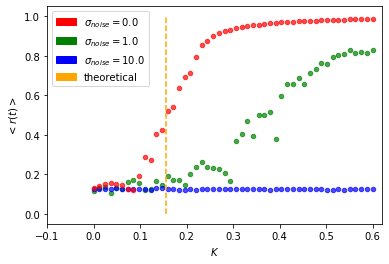

In [12]:
# Plot final order parameter for each coupling value
iters_noise_1 = np.array(iters_noise_1)
iters_noise_10 = np.array(iters_noise_10)
iters_clean = np.array(iters_clean)
fig, ax = plt.subplots(1,1)

# Predicted critical coupling Kc
Kc = np.sqrt(8 / np.pi) * np.std(model.nat_freqs) # analytical result (from paper)
ax.vlines(Kc, 0, 1, linestyles='--', color='orange', label='theoretical prediction')

for i, coupling in enumerate(couplings):
    r_mean = np.mean([r(thetat)
                      for thetat in iters_noise_1[i, :, -1000:].T]) # mean over last 1000 steps
    ax.scatter(coupling, r_mean, c='green', s=20, alpha=0.7)
    r_mean = np.mean([r(thetat)
                      for thetat in iters_noise_10[i, :, -1000:].T]) # mean over last 1000 steps
    ax.scatter(coupling, r_mean, c='blue', s=20, alpha=0.7)
    r_mean = np.mean([r(thetat)
                      for thetat in iters_clean[i, :, -1000:].T]) # mean over last 1000 steps
    ax.scatter(coupling, r_mean, c='red', s=20, alpha=0.7)


red_patch = mpatches.Patch(color='red', label = r'$\sigma_{noise} = 0.0$')
green_patch = mpatches.Patch(color='green', label = r'$\sigma_{noise} = 1.0$')
blue_patch = mpatches.Patch(color='blue', label = r'$\sigma_{noise} = 10.0$')
gold_patch = mpatches.Patch(color='orange', label='theoretical')


plt.legend(handles=[red_patch, green_patch, blue_patch, gold_patch], loc='upper left')
plt.xlim(-0.1,0.62)
plt.ylabel('$<r(t)>$')
plt.xlabel('$K$')
plt.savefig('kuramoto_fig5.png')

In [13]:
# set up couplings matrix
num_osc = 10
np.random.seed(1)
nat_freqs = np.random.normal(1, 0.1, size=num_osc)
np.random.seed(2)
init_thetas = 2 * np.pi * np.random.random(size=num_osc)
np.random.seed()
coup_mat = np.ones((num_osc, num_osc))
np.fill_diagonal(coup_mat, 0.0)
coupling = 1.0

model = Kuramoto(nat_freqs, init_thetas, coupling, coup_mat, dt=0.1, T=50)
theta_mat_0 = model.run(init_thetas)


MOVIES: 50 oscillators 
natural frequencies drawn from $\mathcal{N}(1, 0.1)$
initial thetas uniformly drawn from $[-2π, 2π]$

MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


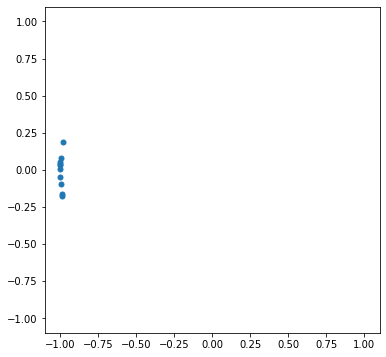

In [14]:

from matplotlib import animation

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
line, = ax.plot([], [], '.',markersize=10)

#plot the background of each frame
def init():
    line.set_data([], [])
    return line,

#animation function
def animate(i):
    x = np.cos(theta_mat_0[:, i])
    y = np.sin(theta_mat_0[:, i])
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=15, blit=True)
anim.save('kuramoto.gif', fps=30, writer='PillowWriter')

plt.show()


In [15]:
# set up couplings matrix
num_osc = 10
np.random.seed(1)
nat_freqs = np.random.normal(1, 0.1, size=num_osc)
np.random.seed(2)
init_thetas = 2 * np.pi * np.random.random(size=num_osc)
np.random.seed()
coup_mat = np.ones((num_osc, num_osc))
np.fill_diagonal(coup_mat, 0.0)
coupling = 0.1

model = Kuramoto(nat_freqs, init_thetas, coupling, coup_mat, dt=0.1, T=50)
theta_mat_0 = model.run(init_thetas)


MovieWriter PillowWriter unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


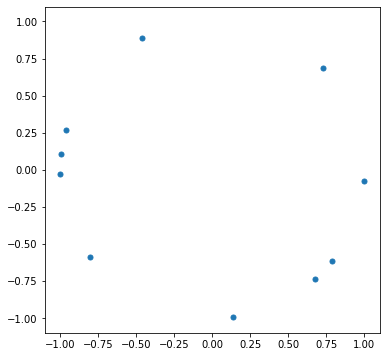

In [16]:

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(xlim=(-1.1, 1.1), ylim=(-1.1, 1.1))
line, = ax.plot([], [], '.',markersize=10)

#plot the background of each frame
def init():
    line.set_data([], [])
    return line,

#animation function
def animate(i):
    x = np.cos(theta_mat_0[:, i])
    y = np.sin(theta_mat_0[:, i])
    line.set_data(x, y)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=15, blit=True)

anim.save('kuramoto_ns.gif', fps=30, writer='PillowWriter')

plt.show()
